In [145]:
import os
import datetime
import math

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from enum import Enum

mpl.rcParams['figure.figsize'] = (25,8)
mpl.rcParams['axes.grid'] = False

### Features:


In [146]:
DO_NOT_USE_EARLY_STOPPING = True
DROP_INDEX_LIKE_COLUMNS = True
WINDOW_WIDTH = 3
LABEL_WIDTH = 1
SHIFT = 1

In [147]:
USED_STORE_ID = 4051653300272
FEATURE_SIZE = 87
DATA_ORIGIN = "Data/merged_cleaned_FE_imputed(v)_w.csv"
DROPPED_COLUMNS = [
    "WeekoftheYear_cos",
    "WeekoftheYear_sin",
    "DayoftheYear_cos",
    "DayoftheYear_sin",
    "Month_cos",
    "Month_sin",
    "Season_Autumn",
    "Season_Spring",
    "Season_Summer",
    "Season_Winter",
]

class PRODUCT_IDs(Enum):
    BensLunchtime = "4260705920294"

In [148]:
def load_data():
    df = pd.read_csv(DATA_ORIGIN, parse_dates=["Date"])
    not_indexed = ["ProductID", "Quantity", "Price_imputed", "Year"]
    df_pivot = df.pivot_table(
        index=[col for col in list(df.columns) if col not in not_indexed],
        columns=["ProductID"],
        values="Quantity",
    )
    df_pivot["total_quantity_day"] = df_pivot.sum(axis=1)

    df_pivot = df_pivot.loc[df_pivot.index.get_level_values("StoreID") == USED_STORE_ID]
    df_pivot = df_pivot.droplevel("StoreID")
    df_pivot = df_pivot.reset_index()
    df_pivot.columns = df_pivot.columns.astype(str)

    return df_pivot


def add_fourier_features(
    data,
    features_to_period={
        "Month": 12.0,
        "DayoftheMonth": 31.0,
        "WeekoftheMonth": 4.0,
        "DayoftheWeek": 7.0,
        "WeekoftheYear": 52.0,
        "DayoftheYear": 365.0,
    },
):
    df = data.copy()

    for column, period in features_to_period.items():
        df[f"{column}_cos"] = np.cos(2 * np.pi * df["Month"] / period)
        df[f"{column}_sin"] = np.sin(2 * np.pi * df["Month"] / period)

    return df.drop(
        features_to_period.keys(),
        axis=1,
    )


def get_dataset():
    df_pivot = load_data()
    date_time = pd.to_datetime(df_pivot.pop("Date"), format="%Y-%m-%d")
    data = add_fourier_features(df_pivot)
    return data, date_time


def split_data(data, train_frac=0.7, valid_frac=0.2, test_frac=0.1):
    if not math.isclose(train_frac + valid_frac + test_frac, 1):
        raise Error("Ivalid split sizes")

    n = len(data)
    train_df = data[0 : int(n * train_frac)]
    val_df = data[int(n * train_frac) : int(n * (train_frac + valid_frac))]
    test_df = data[int(n * (train_frac + valid_frac)) :]

    return train_df, val_df, test_df


def normalize(data, norm_values_to_use=None):
    norm_values_used = norm_values_to_use
    if norm_values_to_use is None:
        std = data.std()
        std = std.where(lambda x: np.invert(np.isclose(x, 0)), other=0.3)
        norm_values_used = {
            "std": std,
            "mean": data.mean(),
        }

    return (data - norm_values_used["mean"]) / (
        norm_values_used["std"]
    ), norm_values_used

In [149]:
data, time = get_dataset()
if DROP_INDEX_LIKE_COLUMNS:
    data = data.drop(
        labels=DROPPED_COLUMNS,
        axis="columns",
    )
train_df, val_df, test_df = split_data(data)

train_df, normalization_params = normalize(train_df)
val_df, _ = normalize(val_df, normalization_params)
test_df, _ = normalize(test_df, normalization_params)
assert FEATURE_SIZE == len(train_df.columns)

In [150]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                train_df, val_df, test_df,
                label_columns=None):
        '''
        This drawing indicates the meaning of the attributes:

        ------------------------Time Dimension ----------------->
                                               |
        <----------total window size---------->|
        <------input width------><---shift---->|
                    <------label width-------->|
                                               |
                                            
        '''
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                                enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        '''
        splits the incoming data: (batch_size, total_window_size, all_features)
        into:
        inputs: (batch_size, input_width, all_features)
        labels: (batch_size, label_width, #label_columns)

        while the timesteps are according to the parameter meaning (see description of class)
        '''
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col=PRODUCT_IDs.BensLunchtime.value, max_subplots=3, used_normalization=None):
        def denormalize(data):
            if used_normalization is None:
                return data
            return data * used_normalization['std'][plot_col] + used_normalization['mean'][plot_col]

        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, denormalize(inputs[n, :, plot_col_index]),
                    label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, denormalize(labels[n, :, label_col_index]),
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)

            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, denormalize(predictions[n, :, label_col_index]),
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

            plt.xlabel('Time [day]')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)

        ds = ds.map(self.split_window)

        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

-----
# General Settings

In [151]:
## For tracking Model Performances:
val_performance = {}
performance = {}
train_performance = {}

In [152]:
def get_loss():
    ## !!! change function save_performance when changing here
    return tf.keras.losses.MeanSquaredError()


def get_metrics():
    ## !!! change function save_performance when changing here
    return [tf.keras.metrics.MeanAbsoluteError()]


def save_performance(where):
    df = pd.DataFrame(
        columns=[
            "MSE_Training",
            "MSE_Validation",
            "MSE_Test",
            "MAE_Training",
            "MAE_Validation",
            "MAE_Test",
        ]
    )

    for model_name in performance.keys():
        df.loc[model_name] = [
            train_performance[model_name][0],
            val_performance[model_name][0],
            performance[model_name][0],
            train_performance[model_name][1],
            val_performance[model_name][1],
            performance[model_name][1],
        ]
    df.to_csv(where)


def register_performance(name, model, window_generator):
    val_performance[name] = model.evaluate(window_generator.val, verbose=0)
    performance[name] = model.evaluate(window_generator.test, verbose=0)
    train_performance[name] = model.evaluate(window_generator.train, verbose=0)

---

## Single Step Models

In [153]:
single_step_window = WindowGenerator(
    input_width=WINDOW_WIDTH,
    label_width=LABEL_WIDTH,
    shift=SHIFT,
    label_columns=[PRODUCT_IDs.BensLunchtime.value],
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
)
single_step_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['4260705920294']

## Baseline

In [154]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index, forecasting_width):
        super().__init__()
        self.label_index = label_index
        self.forecasting_width = forecasting_width

    def call(self, inputs):
        result = inputs[:, -self.forecasting_width :, self.label_index]
        return result[:, :, tf.newaxis]

In [155]:
baseline = Baseline(
    label_index=single_step_window.column_indices[PRODUCT_IDs.BensLunchtime.value],
    forecasting_width=single_step_window.label_width
)

baseline.compile(loss=get_loss(), metrics=get_metrics())

register_performance('Baseline', baseline, single_step_window)

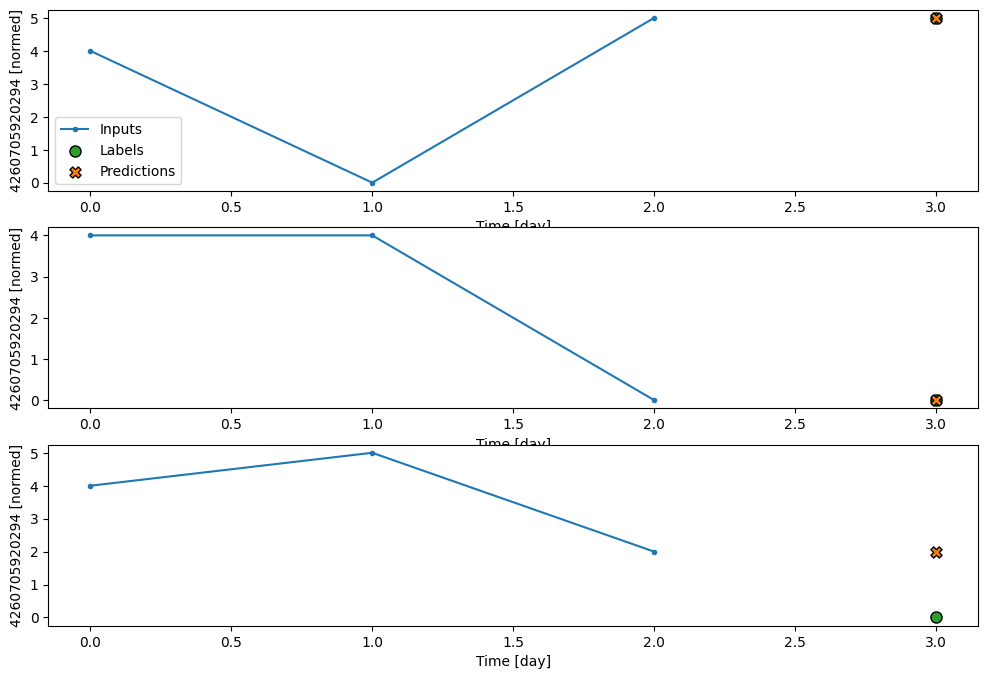

In [156]:
single_step_window.plot(baseline, used_normalization=normalization_params)

In [157]:
MAX_EPOCHS = 50


def compile_and_fit(model, window, patience=2, epochs=MAX_EPOCHS):
    if not DO_NOT_USE_EARLY_STOPPING:
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=patience, mode="min"
        )

    model.compile(
        loss=get_loss(), optimizer=tf.keras.optimizers.Adam(), metrics=get_metrics()
    )

    callbacks = [early_stopping if not DO_NOT_USE_EARLY_STOPPING else None]

    history = model.fit(
        window.train,
        epochs=epochs,
        validation_data=window.val,
        callbacks=[func for func in callbacks if func is not None],
    )
    return history

## Linear Model

In [158]:
linear = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(WINDOW_WIDTH, FEATURE_SIZE)),
        tf.keras.layers.Dense(units=LABEL_WIDTH),
        tf.keras.layers.Reshape(target_shape=(LABEL_WIDTH, 1)),
    ]
)

linear.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_19 (Flatten)        (None, 261)               0         
                                                                 
 dense_43 (Dense)            (None, 1)                 262       
                                                                 
 reshape_21 (Reshape)        (None, 1, 1)              0         
                                                                 
Total params: 262
Trainable params: 262
Non-trainable params: 0
_________________________________________________________________


In [159]:
history = compile_and_fit(linear, single_step_window)

register_performance('Linear', linear, single_step_window)

Epoch 1/50
6/6 [==============================] - 1s 37ms/step - loss: 2.7043 - mean_absolute_error: 1.2798 - val_loss: 4.2964 - val_mean_absolute_error: 1.4814
Epoch 2/50
6/6 [==============================] - 0s 11ms/step - loss: 2.3647 - mean_absolute_error: 1.1966 - val_loss: 3.7548 - val_mean_absolute_error: 1.3736
Epoch 3/50
6/6 [==============================] - 0s 10ms/step - loss: 2.0526 - mean_absolute_error: 1.1233 - val_loss: 3.7453 - val_mean_absolute_error: 1.4257
Epoch 4/50
6/6 [==============================] - 0s 20ms/step - loss: 1.8762 - mean_absolute_error: 1.0825 - val_loss: 3.9242 - val_mean_absolute_error: 1.5264
Epoch 5/50
6/6 [==============================] - 0s 12ms/step - loss: 1.7334 - mean_absolute_error: 1.0447 - val_loss: 4.1098 - val_mean_absolute_error: 1.6039
Epoch 6/50
6/6 [==============================] - 0s 11ms/step - loss: 1.6228 - mean_absolute_error: 1.0123 - val_loss: 4.1923 - val_mean_absolute_error: 1.6331
Epoch 7/50
6/6 [==================

In [160]:
def plot_history(history):
    plt.plot(history.history['loss'], label='Loss(Train)')
    plt.plot(history.history['val_loss'], label='Loss(Validation)')
    plt.plot(history.history['mean_absolute_error'], label='MAE(Train)')
    plt.plot(history.history['val_mean_absolute_error'], label='MAE(Validation)')
    plt.legend()

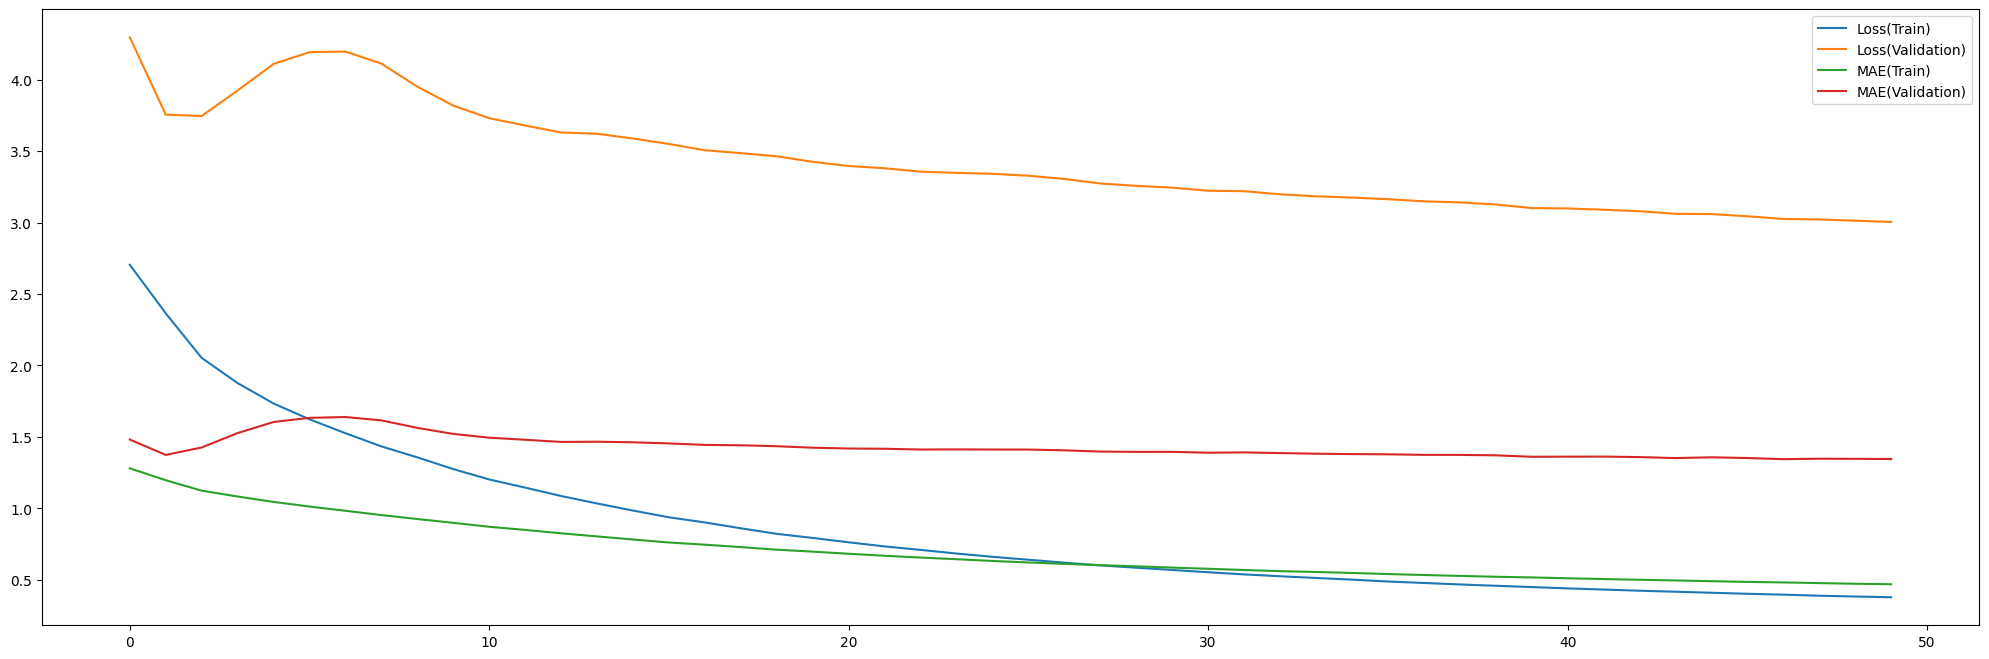

In [161]:
plot_history(history)

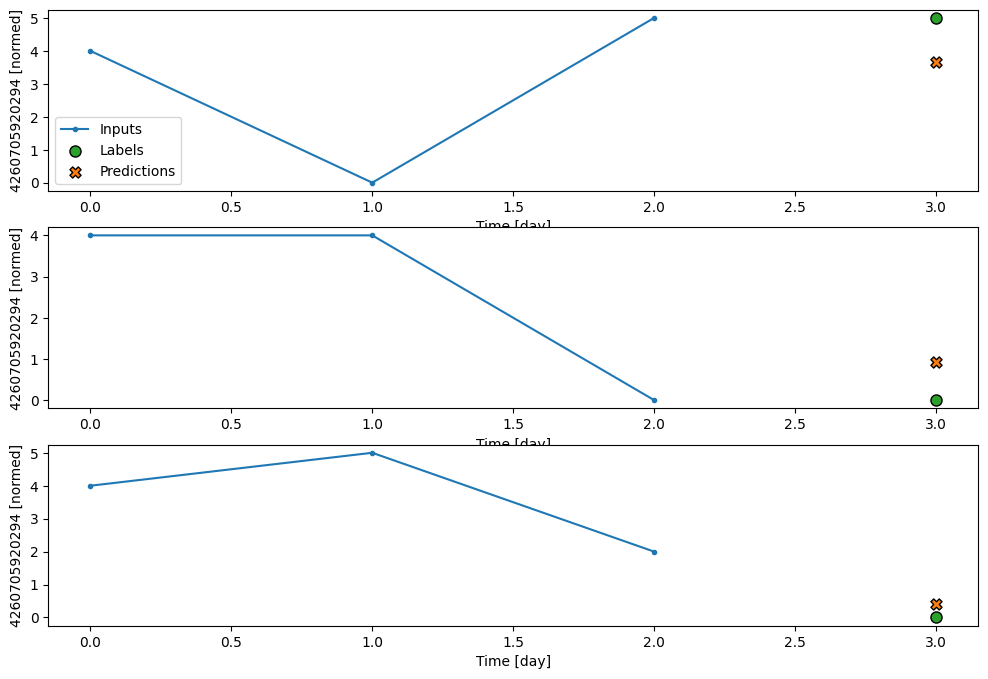

In [162]:
single_step_window.plot(linear, used_normalization=normalization_params)

## Dense Model

In [163]:
dense = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(WINDOW_WIDTH, FEATURE_SIZE)),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dropout(rate=0.8),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dropout(rate=0.8),
    tf.keras.layers.Dense(units=LABEL_WIDTH),
    tf.keras.layers.Reshape(target_shape=(LABEL_WIDTH, 1))
])
print(dense.summary())

history = compile_and_fit(dense, single_step_window, epochs=100)

register_performance('Dense', dense, single_step_window)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_20 (Flatten)        (None, 261)               0         
                                                                 
 dense_44 (Dense)            (None, 64)                16768     
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_45 (Dense)            (None, 64)                4160      
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_46 (Dense)            (None, 1)                 65        
                                                                 
 reshape_22 (Reshape)        (None, 1, 1)            

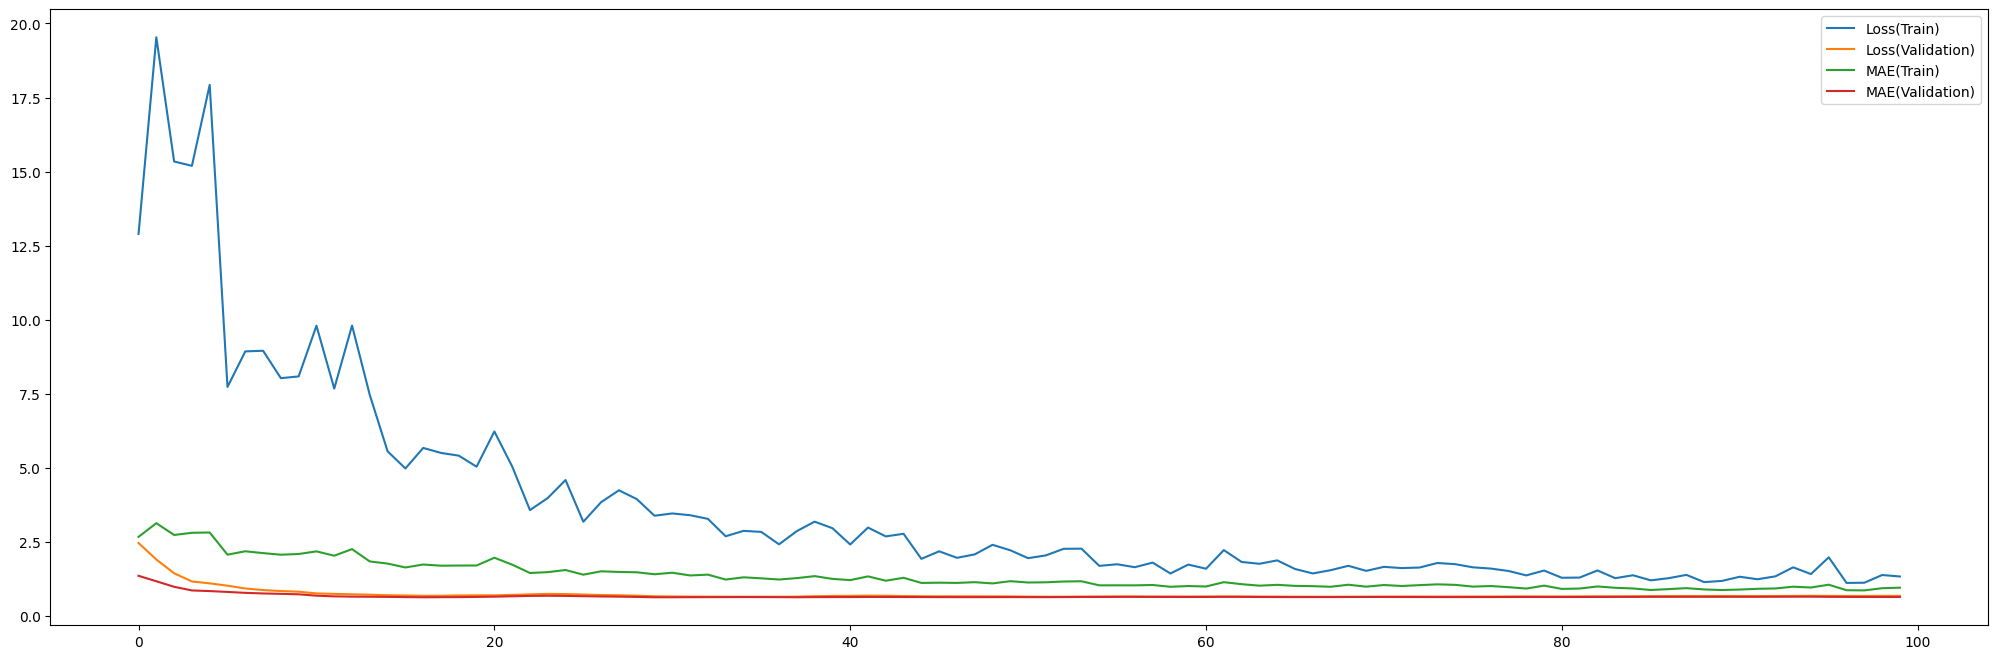

In [164]:
plot_history(history)

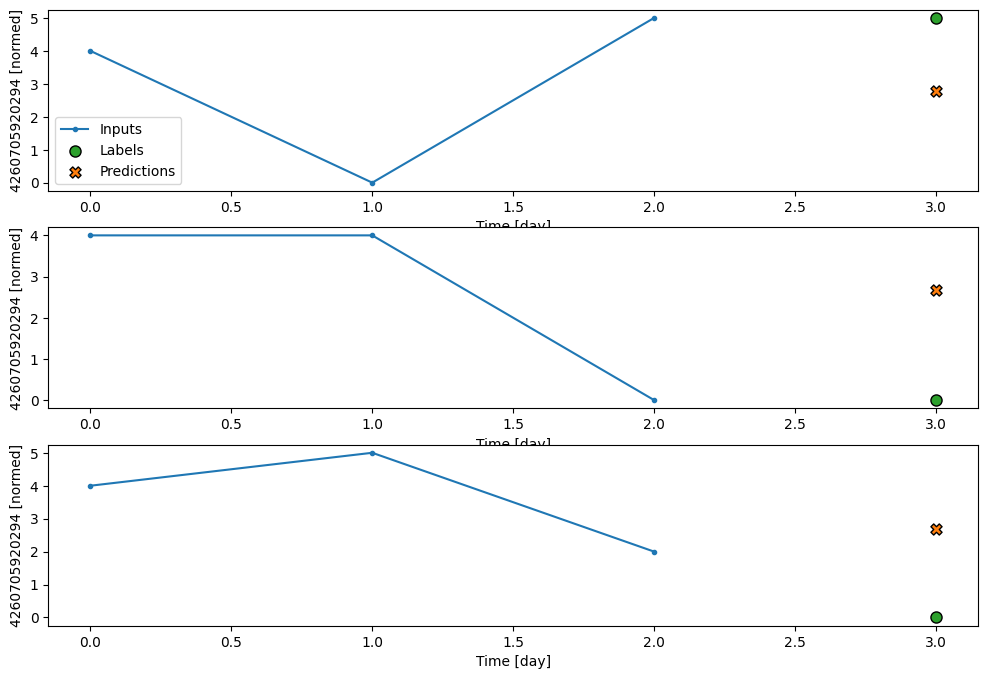

In [165]:
single_step_window.plot(dense, used_normalization=normalization_params)

## Multi Step Dense

In [166]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=LABEL_WIDTH,
    shift=SHIFT,
    label_columns=[PRODUCT_IDs.BensLunchtime.value],
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
)

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['4260705920294']

In [167]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(input_shape=(WINDOW_WIDTH, FEATURE_SIZE)),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dropout(rate=0.8),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dropout(rate=0.8),
    tf.keras.layers.Dense(units=LABEL_WIDTH),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape(target_shape=(LABEL_WIDTH, 1))
])
multi_step_dense.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_21 (Flatten)        (None, 261)               0         
                                                                 
 dense_47 (Dense)            (None, 32)                8384      
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                                 
 dense_48 (Dense)            (None, 32)                1056      
                                                                 
 dropout_14 (Dropout)        (None, 32)                0         
                                                                 
 dense_49 (Dense)            (None, 1)                 33        
                                                                 
 reshape_23 (Reshape)        (None, 1, 1)            

In [168]:
history = compile_and_fit(multi_step_dense, single_step_window, epochs=100)

register_performance('Multi step dense', multi_step_dense, single_step_window)

Epoch 1/100
6/6 [==============================] - 1s 46ms/step - loss: 16.3531 - mean_absolute_error: 2.9615 - val_loss: 1.2561 - val_mean_absolute_error: 0.8622
Epoch 2/100
6/6 [==============================] - 0s 29ms/step - loss: 15.6371 - mean_absolute_error: 2.6142 - val_loss: 1.3062 - val_mean_absolute_error: 0.8700
Epoch 3/100
6/6 [==============================] - 0s 45ms/step - loss: 17.1115 - mean_absolute_error: 2.8216 - val_loss: 1.3542 - val_mean_absolute_error: 0.8815
Epoch 4/100
6/6 [==============================] - 0s 30ms/step - loss: 10.9161 - mean_absolute_error: 2.1630 - val_loss: 1.3542 - val_mean_absolute_error: 0.8765
Epoch 5/100
6/6 [==============================] - 0s 29ms/step - loss: 18.6508 - mean_absolute_error: 2.7788 - val_loss: 1.2602 - val_mean_absolute_error: 0.8329
Epoch 6/100
6/6 [==============================] - 0s 46ms/step - loss: 13.0338 - mean_absolute_error: 2.5771 - val_loss: 1.2106 - val_mean_absolute_error: 0.8058
Epoch 7/100
6/6 [=====

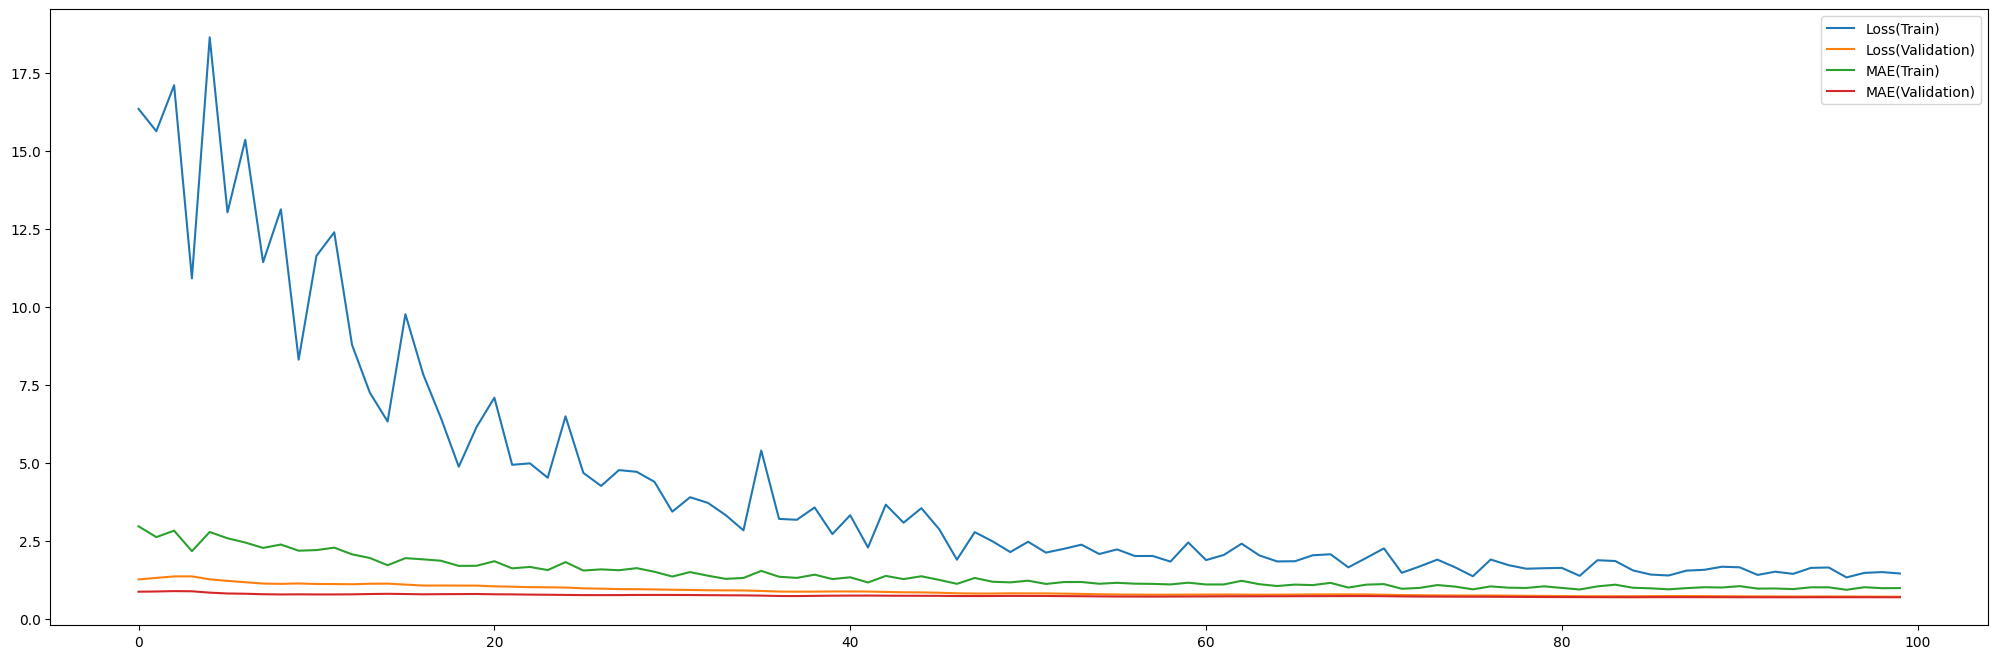

In [169]:
plot_history(history)

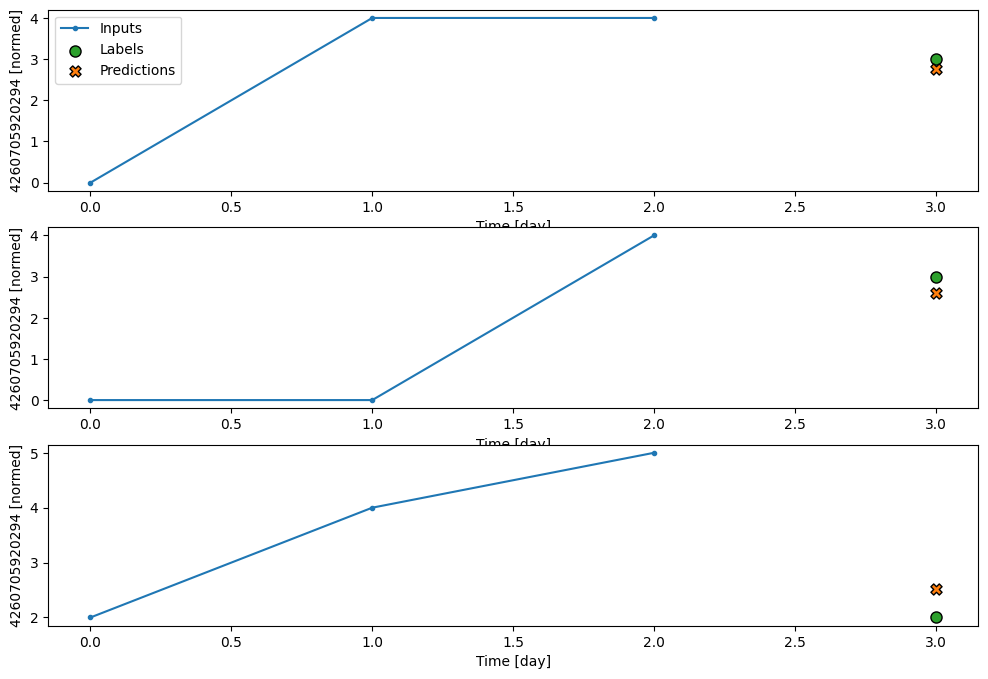

In [170]:
conv_window.plot(multi_step_dense, used_normalization=normalization_params)

## Convolutional

In [171]:
conv_model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv1D(
            input_shape=(CONV_WIDTH, FEATURE_SIZE),
            filters=32,
            kernel_size=(CONV_WIDTH,),
            activation="relu",
        ),
        tf.keras.layers.Dense(units=32, activation="relu"),
        tf.keras.layers.Dense(units=LABEL_WIDTH),
        tf.keras.layers.Reshape(target_shape=(LABEL_WIDTH, 1)),
    ]
)

In [172]:
history = compile_and_fit(conv_model, conv_window)

register_performance('Conv', conv_model, conv_window)

Epoch 1/50
6/6 [==============================] - 1s 52ms/step - loss: 1.4793 - mean_absolute_error: 1.0121 - val_loss: 1.5730 - val_mean_absolute_error: 1.0398
Epoch 2/50
6/6 [==============================] - 0s 16ms/step - loss: 0.9693 - mean_absolute_error: 0.8108 - val_loss: 2.1292 - val_mean_absolute_error: 1.2206
Epoch 3/50
6/6 [==============================] - 0s 13ms/step - loss: 0.7637 - mean_absolute_error: 0.7129 - val_loss: 1.8869 - val_mean_absolute_error: 1.1382
Epoch 4/50
6/6 [==============================] - 0s 13ms/step - loss: 0.6162 - mean_absolute_error: 0.6355 - val_loss: 1.6229 - val_mean_absolute_error: 1.0419
Epoch 5/50
6/6 [==============================] - 0s 12ms/step - loss: 0.5024 - mean_absolute_error: 0.5671 - val_loss: 1.5330 - val_mean_absolute_error: 1.0088
Epoch 6/50
6/6 [==============================] - 0s 13ms/step - loss: 0.4134 - mean_absolute_error: 0.5079 - val_loss: 1.6550 - val_mean_absolute_error: 1.0444
Epoch 7/50
6/6 [==================

In [173]:
WIDE_LABEL_WIDTH = 6
WIDE_INPUT_WIDTH = WIDE_LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=WIDE_INPUT_WIDTH,
    label_width=WIDE_LABEL_WIDTH,
    shift=1,
    label_columns=["4260705920294"],
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
)

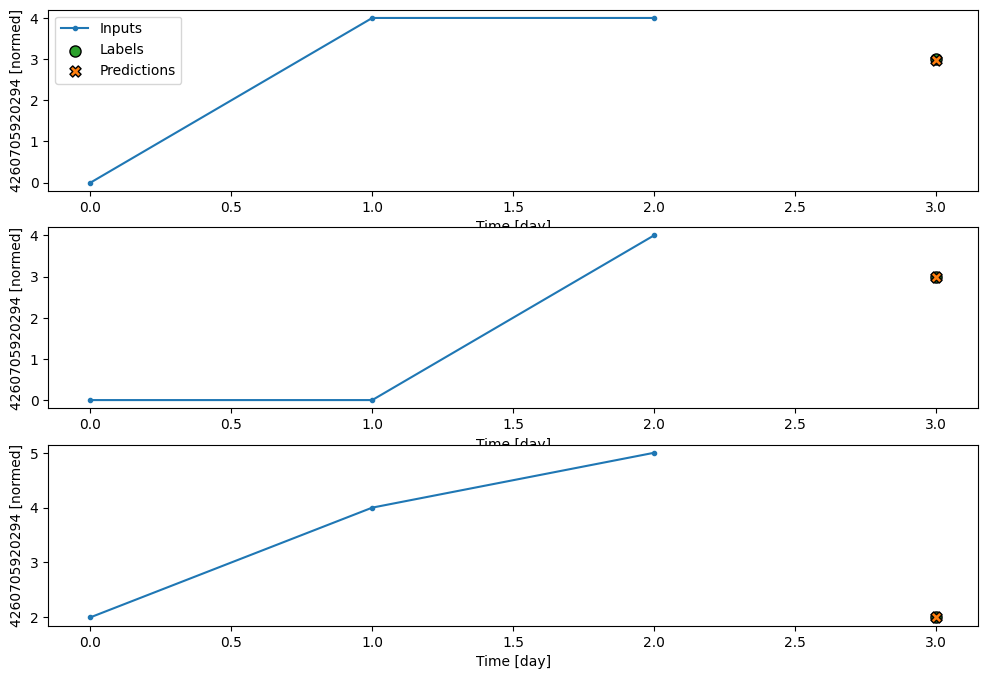

In [174]:
conv_window.plot(conv_model, used_normalization=normalization_params)

## RNN

In [175]:

lstm_model = tf.keras.models.Sequential(
    [
        # Shape [batch, time, features] => [batch, time, lstm_units]
        tf.keras.layers.LSTM(32, return_sequences=True, input_shape=(WINDOW_WIDTH, FEATURE_SIZE)),
        tf.keras.layers.Flatten(),
        # Shape => [batch, time, features]
        tf.keras.layers.Dense(units=LABEL_WIDTH),
        tf.keras.layers.Reshape(target_shape=(LABEL_WIDTH, 1)),
    ]
)
lstm_model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 3, 32)             15360     
                                                                 
 flatten_22 (Flatten)        (None, 96)                0         
                                                                 
 dense_52 (Dense)            (None, 1)                 97        
                                                                 
 reshape_25 (Reshape)        (None, 1, 1)              0         
                                                                 
Total params: 15,457
Trainable params: 15,457
Non-trainable params: 0
_________________________________________________________________


In [176]:
history = compile_and_fit(lstm_model, single_step_window)

register_performance('LSTM', lstm_model, single_step_window)

Epoch 1/50
6/6 [==============================] - 3s 134ms/step - loss: 1.0876 - mean_absolute_error: 0.8605 - val_loss: 0.7272 - val_mean_absolute_error: 0.6629
Epoch 2/50
6/6 [==============================] - 0s 23ms/step - loss: 0.9601 - mean_absolute_error: 0.8080 - val_loss: 0.6802 - val_mean_absolute_error: 0.6564
Epoch 3/50
6/6 [==============================] - 0s 14ms/step - loss: 0.8723 - mean_absolute_error: 0.7702 - val_loss: 0.6556 - val_mean_absolute_error: 0.6506
Epoch 4/50
6/6 [==============================] - 0s 14ms/step - loss: 0.7993 - mean_absolute_error: 0.7392 - val_loss: 0.6425 - val_mean_absolute_error: 0.6479
Epoch 5/50
6/6 [==============================] - 0s 13ms/step - loss: 0.7382 - mean_absolute_error: 0.7087 - val_loss: 0.6310 - val_mean_absolute_error: 0.6443
Epoch 6/50
6/6 [==============================] - 0s 16ms/step - loss: 0.6778 - mean_absolute_error: 0.6787 - val_loss: 0.6267 - val_mean_absolute_error: 0.6425
Epoch 7/50
6/6 [=================

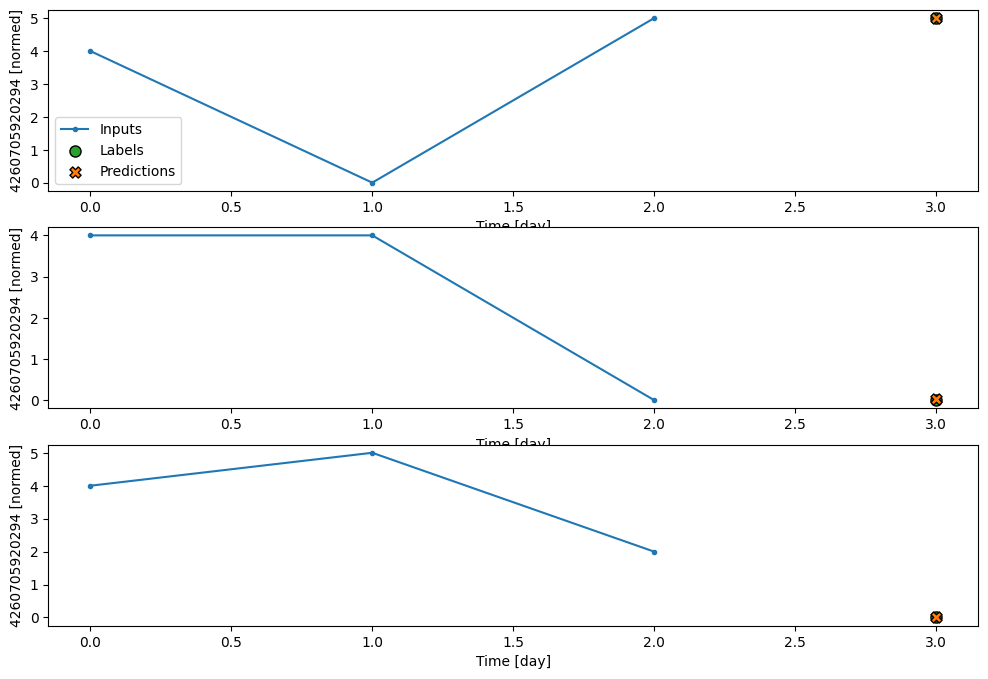

In [177]:
single_step_window.plot(lstm_model, used_normalization=normalization_params)

# Performance Comparison

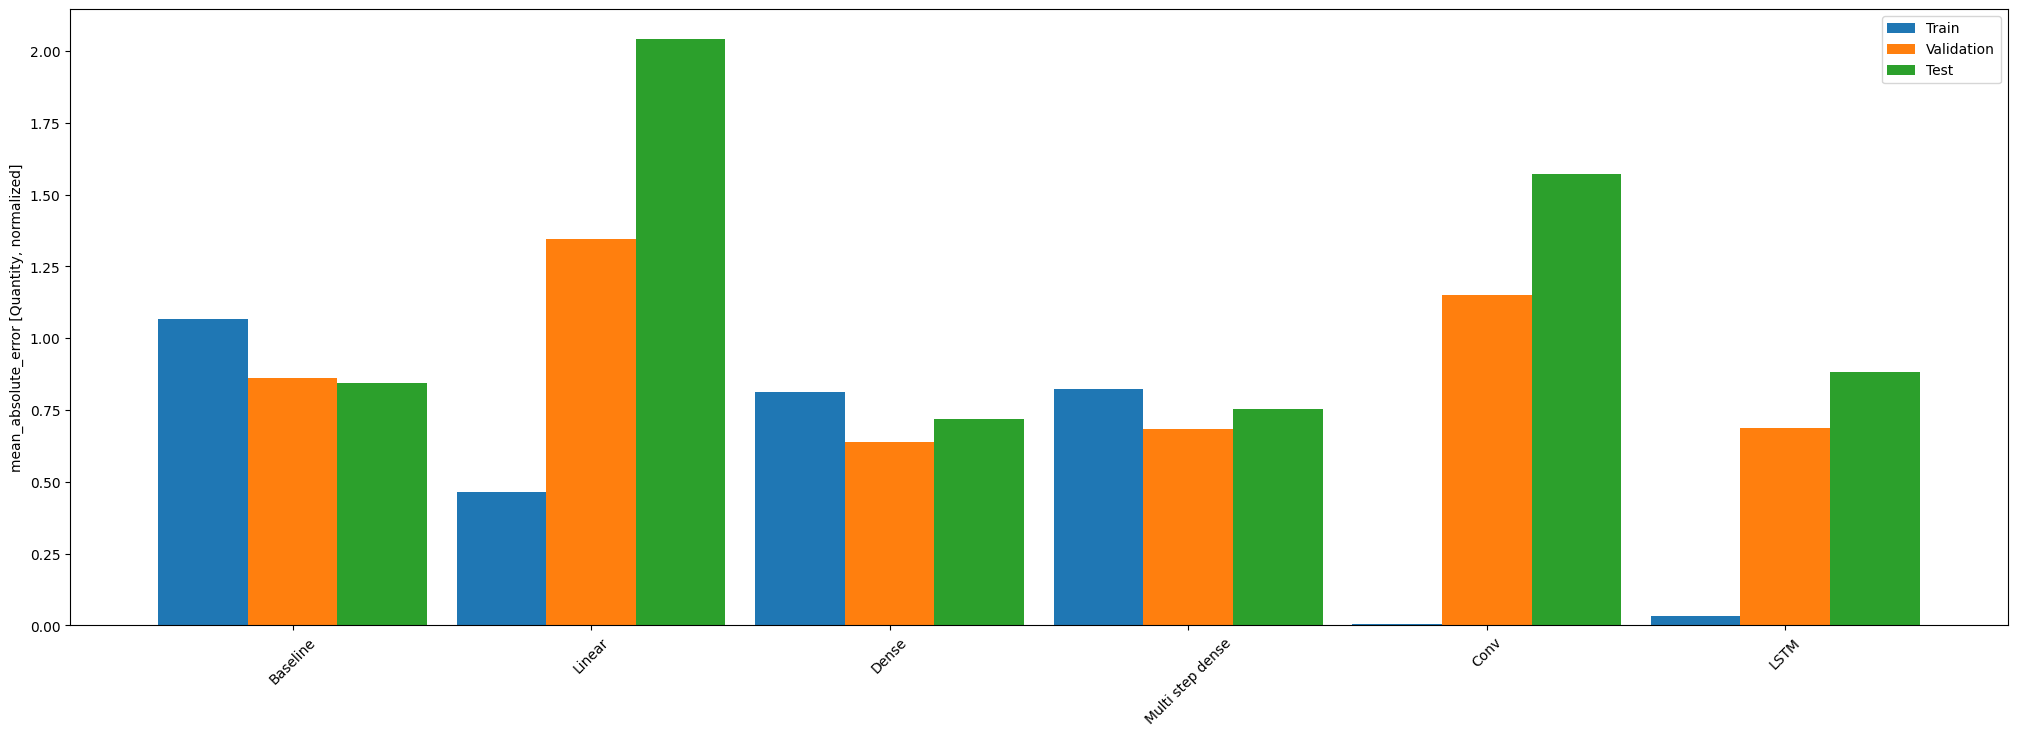

In [178]:
x = np.arange(len(performance))
width = 0.3
metric_name = "mean_absolute_error"
metric_index = lstm_model.metrics_names.index("mean_absolute_error")
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]
train_mae = [v[metric_index] for v in train_performance.values()]

plt.ylabel("mean_absolute_error [Quantity, normalized]")
plt.bar(x - 0.3, train_mae, width, label="Train")
plt.bar(x, val_mae, width, label="Validation")
plt.bar(x + 0.3, test_mae, width, label="Test")
plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
_ = plt.legend()
plt.savefig(f'optimization/{datetime.datetime.today().strftime("%Y%m%d_%H%M%S")}.jpg')
save_performance(
    f'optimization/{datetime.datetime.today().strftime("%Y%m%d_%H%M%S")}.csv'
)